# Project 2: Natural Language Processing
Authors: Zechen Wu, Elena Franchini, Erifeoluwa Jamgbadi

# Investigate dataset

## Dataset selection
The dataset we will use is the "SQuAD2.0: The Stanford Question Answering Dataset". The website provides the training and validation (i.e. development) set in the form of JSON.


## Dataset analysis
Data in the training set consists of strings which represent questions and answers (that come from Wikipedia articles) and can be found as values under the 'data' key. Each 'title' key is associated to a 'paragraphs' key which is an array containing these questions and answers associated to that title (the title acts as a category). Each question is composed by the text representing the question, the id, an array of answers and a flag checking if answering to that question is impossible: if the flag is true, the array of answers is empty. In addition, each answer is associated to the 'answer_start' key whose value represent the starting position of the answer.
Some questions have also plausible answers, which should be other possible answers in addition to the correct ones (if any).

In [1]:
!git clone https://github.com/Ele975/AML_project2.git
!pip install --upgrade gensim
!pip install -U sentence-transformers
!pip install torchinfo
!pip install datasets
!pip install hnswlib

fatal: destination path 'AML_project2' already exists and is not an empty directory.


In [2]:
#!pip install --upgrade transformers

In [3]:
import pandas as pd
import json
import math
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec

##model parts imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model


##for calculating the accuracy of the model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# import data from github repository
train = pd.read_json('AML_project2/train-v2.0.json')
val = pd.read_json('AML_project2/dev-v2.0.json')
print(train)
print(val)

    version                                               data
0      v2.0  {'title': 'Beyoncé', 'paragraphs': [{'qas': [{...
1      v2.0  {'title': 'Frédéric_Chopin', 'paragraphs': [{'...
2      v2.0  {'title': 'Sino-Tibetan_relations_during_the_M...
3      v2.0  {'title': 'IPod', 'paragraphs': [{'qas': [{'qu...
4      v2.0  {'title': 'The_Legend_of_Zelda:_Twilight_Princ...
..      ...                                                ...
437    v2.0  {'title': 'Infection', 'paragraphs': [{'qas': ...
438    v2.0  {'title': 'Hunting', 'paragraphs': [{'qas': [{...
439    v2.0  {'title': 'Kathmandu', 'paragraphs': [{'qas': ...
440    v2.0  {'title': 'Myocardial_infarction', 'paragraphs...
441    v2.0  {'title': 'Matter', 'paragraphs': [{'qas': [{'...

[442 rows x 2 columns]
   version                                               data
0     v2.0  {'title': 'Normans', 'paragraphs': [{'qas': [{...
1     v2.0  {'title': 'Computational_complexity_theory', '...
2     v2.0  {'title': 'Southern_Ca

This shows the structure of the json file, it has title, which is the topic, then the questions, the answers to those questions and the id of the questions. In the datasets, the questions and answers are organised under different topics.

In [5]:
trainingCol = train.columns
trainingCol
train.iloc[0, 1]["paragraphs"]


[{'qas': [{'question': 'When did Beyonce start becoming popular?',
    'id': '56be85543aeaaa14008c9063',
    'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
    'is_impossible': False},
   {'question': 'What areas did Beyonce compete in when she was growing up?',
    'id': '56be85543aeaaa14008c9065',
    'answers': [{'text': 'singing and dancing', 'answer_start': 207}],
    'is_impossible': False},
   {'question': "When did Beyonce leave Destiny's Child and become a solo singer?",
    'id': '56be85543aeaaa14008c9066',
    'answers': [{'text': '2003', 'answer_start': 526}],
    'is_impossible': False},
   {'question': 'In what city and state did Beyonce  grow up? ',
    'id': '56bf6b0f3aeaaa14008c9601',
    'answers': [{'text': 'Houston, Texas', 'answer_start': 166}],
    'is_impossible': False},
   {'question': 'In which decade did Beyonce become famous?',
    'id': '56bf6b0f3aeaaa14008c9602',
    'answers': [{'text': 'late 1990s', 'answer_start': 276}],
    'is_imposs

In [6]:
##title, paragraphs and context
train.iloc[1]["data"]["paragraphs"]

[{'qas': [{'question': "What was Frédéric's nationalities?",
    'id': '56cbd2356d243a140015ed66',
    'answers': [{'text': 'Polish and French', 'answer_start': 182}],
    'is_impossible': False},
   {'question': 'In what era was Frédéric active in?',
    'id': '56cbd2356d243a140015ed67',
    'answers': [{'text': 'Romantic era', 'answer_start': 276}],
    'is_impossible': False},
   {'question': 'For what instrument did Frédéric write primarily for?',
    'id': '56cbd2356d243a140015ed68',
    'answers': [{'text': 'solo piano', 'answer_start': 318}],
    'is_impossible': False},
   {'question': 'In what area was Frédéric born in?',
    'id': '56cbd2356d243a140015ed69',
    'answers': [{'text': 'Duchy of Warsaw', 'answer_start': 559}],
    'is_impossible': False},
   {'question': 'At what age did Frédéric depart from Poland?',
    'id': '56cbd2356d243a140015ed6a',
    'answers': [{'text': '20', 'answer_start': 777}],
    'is_impossible': False},
   {'question': 'What year was Chopin born

In [7]:
for i in trainingCol[0:10]:
  train.iloc[0, 1]["title"]

### Count the number of data we have in both the training and validation sets.
The size of the dataset is quite small, but the partition between the training and validation set is good (since always we have a traning set much bigger than the validation set). Often the dataset is first split in traning and test set, since the validation set is obtained by further splitting the training set. In this case is it required to get the test set from the training set.

In [8]:
def count_data(series):
  nr_categories = 0
  nr_questions = 0
  nr_answers = 0

  for category in series:
    nr_categories += 1
    paragraphs = category.get('paragraphs', [])
    for para in paragraphs:
      qas_list = para.get('qas', [])
      nr_questions += len(qas_list)
      for qas in qas_list:
        answers = qas.get('answers', [])
        nr_answers += len(answers)
  return nr_categories, nr_questions, nr_answers

count_train = count_data(train['data'])
count_val = count_data(val['data']);

print("Categories in the training set:", count_train[0])
print("Categories in the validation set:", count_val[0], "\n")
print("Questions in the training set:", count_train[1])
print("Questions in the validation set:", count_val[1], "\n")
print("Answers in the training set:", count_train[2])
print("Answers in the validation set:", count_val[2], "\n")

print('Total data in training set (Q + A):', count_train[1] + count_train[2])
print('Total data in validation set (Q + A):', count_val[1] + count_val[2], "\n")

print('Total data in dataset (Q + A):', count_train[1] + count_train[2] + count_val[1] + count_val[2], "\n")

print('Partition dataset:')
print('\t Training set:',round((count_train[1] + count_train[2])/(count_train[1] + count_train[2] + count_val[1] + count_val[2])*100) , '%.')
print('\t Validation set:',round((count_val[1] + count_val[2])/(count_train[1] + count_train[2] + count_val[1] + count_val[2])*100) , '%.')


Categories in the training set: 442
Categories in the validation set: 35 

Questions in the training set: 130319
Questions in the validation set: 11873 

Answers in the training set: 86821
Answers in the validation set: 20302 

Total data in training set (Q + A): 217140
Total data in validation set (Q + A): 32175 

Total data in dataset (Q + A): 249315 

Partition dataset:
	 Training set: 87 %.
	 Validation set: 13 %.


### Define the vocabulary size which is given by the number of distinct words in the collection.
To compute the size of the vocabulary (only of the input collection) we need first to split the questions strings (not the answers since we analyse the input only) into words and inserting them in a set which do not allow duplicates (the vocabulary size takes into consideration only distinct words). Regex are used to remove characters we don't need for the analysis and for a potential model, e.g. underscores, numbers, etc. Stop words (most common words) are removed since they don't give additional value for our statistics. In the vocabulary size there are also considered some wrong written words (e.g. aan instead of 'an'), and it is not performant to remove them manually, but since they are only a few with respect to the amount of different words we have, they'll do not influence our results.

In [9]:

# all words
words_total = []


def input_vocabulary(series):
  words_set = set()
  words_total_sets = []
  # list of tokenised questions
  text_to_sentence = []
  text_to_sentence_no_stopwords = []
  for category in series:
    paragraphs = category.get('paragraphs', [])
    for para in paragraphs:
      qas_list = para.get('qas', [])
      for qa in qas_list:
        # set lower case
        question = qa.get('question', '').lower()
        # remove punctuation, split '/' and numbers and words with numbers
        clean_question = re.sub(r'[^\w\s/]', '', question)
        clean_question = re.sub(r'/', ' ', clean_question)
        clean_question = re.sub(r'\b(?:\w*\d\w*|\d+)\b', '', clean_question)
        clean_question = re.sub(r'_', '', clean_question)
        words = clean_question.split()
        text_to_sentence_no_stopwords.append(words)
        # remove stopwords
        words_nostopwords = [w for w in words if w not in stopwords.words('english')]
        text_to_sentence.append(words_nostopwords)
        for word in words_nostopwords:
          # unique words for each set (frequency = 1)
          words_set.add(word)
          # all words for each set
          words_total_sets.append(word)
          # all words for both sets
          words_total.append(word)
  return words_set, words_total_sets, text_to_sentence, text_to_sentence_no_stopwords

words_set_train, words_total_train, text_to_sentence_train, text_to_sentence_no_stopwords_train = input_vocabulary(train['data'])
words_set_val, words_total_val, text_to_sentence_val, text_to_sentence_no_stopwords_val = input_vocabulary(val['data'])

print("vocabulary size of training set:", len(words_set_train))
print("vocabulary size of validation set:", len(words_set_val))
print("total vocabulary size of collection:",  len(words_set_train) + len(words_set_val))



print(text_to_sentence_train[:30])


vocabulary size of training set: 44919
vocabulary size of validation set: 9835
total vocabulary size of collection: 54754
[['beyonce', 'start', 'becoming', 'popular'], ['areas', 'beyonce', 'compete', 'growing'], ['beyonce', 'leave', 'destinys', 'child', 'become', 'solo', 'singer'], ['city', 'state', 'beyonce', 'grow'], ['decade', 'beyonce', 'become', 'famous'], ['rb', 'group', 'lead', 'singer'], ['album', 'made', 'worldwide', 'known', 'artist'], ['managed', 'destinys', 'child', 'group'], ['beyoncé', 'rise', 'fame'], ['role', 'beyoncé', 'destinys', 'child'], ['first', 'album', 'beyoncé', 'released', 'solo', 'artist'], ['beyoncé', 'release', 'dangerously', 'love'], ['many', 'grammy', 'awards', 'beyoncé', 'win', 'first', 'solo', 'album'], ['beyoncés', 'role', 'destinys', 'child'], ['name', 'beyoncés', 'first', 'solo', 'album'], ['second', 'solo', 'album', 'entertainment', 'venture', 'beyonce', 'explore'], ['artist', 'beyonce', 'marry'], ['set', 'record', 'grammys', 'many', 'beyonce', 'win

### Distributions over document length
To compute the distributions over the document length at first we counts the frequency of each term within the input collection. Here we can notice the words written incorrectly are the ones which can be rarely found in the collection (one or few occurences), but again we cannot remove them since there are a lot of grammatically correct words that also occurs rarely. An additional observation is the fact that the training and validation sets have some of the most frequent words in common (e.g. many, yera, name, type, one, ...).

In [10]:
counts_train = nltk.Counter(words_total_train)
counts_val = nltk.Counter(words_total_val)
counts_total = nltk.Counter(words_total)

print("Words count in training set:")
print(counts_train)
print("Words count in validation set:")
print(counts_val)
print("Words count in entire collection:")
print(counts_total)

Words count in training set:
Counter({'many': 7816, 'year': 5450, 'first': 3840, 'name': 3663, 'used': 3239, 'type': 3043, 'new': 2362, 'people': 2280, 'city': 2157, 'one': 2016, 'use': 1891, 'two': 1828, 'much': 1819, 'called': 1747, 'century': 1604, 'war': 1580, 'us': 1539, 'time': 1507, 'country': 1470, 'group': 1422, 'term': 1379, 'system': 1377, 'state': 1357, 'located': 1348, 'part': 1329, 'world': 1315, 'made': 1307, 'language': 1306, 'known': 1289, 'kind': 1276, 'population': 1181, 'percentage': 1164, 'states': 1162, 'long': 1142, 'would': 1110, 'become': 1102, 'government': 1085, 'american': 1067, 'area': 1023, 'school': 973, 'found': 971, 'considered': 968, 'period': 955, 'take': 948, 'begin': 942, 'work': 922, 'company': 922, 'law': 921, 'years': 920, 'along': 914, 'music': 911, 'university': 905, 'make': 878, 'united': 864, 'created': 855, 'church': 809, 'place': 809, 'countries': 809, 'power': 776, 'form': 772, 'another': 772, 'last': 771, 'british': 769, 'end': 768, 'earl

Plot the distribution of the 10 most common words in the entire collection (training and validation set). We can obviously notice that these words are generally common in texts but despite of this their value is important with respect to the one of the most common words since they can give a general idea about the majority types of questions. By the result, some words are not useful to get come conclusions (e.g. 'many', 'first'), but others can be more interesting (e.g. 'people' that can tells there are many questions based on persons, 'city' that can be associated with questions about population, geography, history, etc., 'year' that can be associated to history questions with a specific year of an event occurred in the past). The resulting graph can tells that there can be many historical and geographical questions.

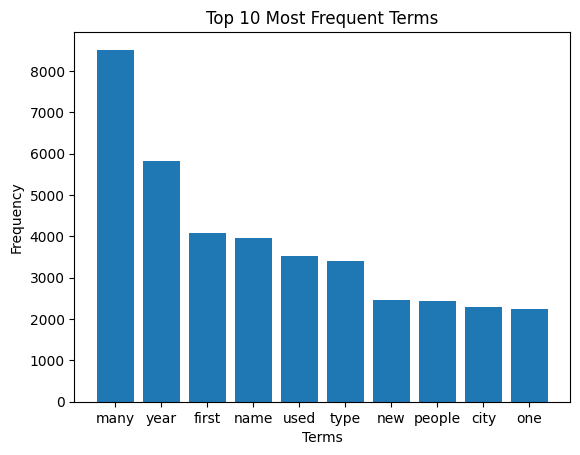

In [11]:
import matplotlib.pyplot as plt

most_common_words = counts_total.most_common(10)
terms, frequencies = zip(*most_common_words)

# Plot the distribution of the 10 most frequent words
plt.bar(terms, frequencies)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Terms')
plt.show()

## Word2Vec embedding

Word2Vec is used for NLP which is able to detect synonymous words or to suggest additional words from uncompleted sentences, and it is able to produce word embedding (words with similar meaning have similar representation). Depending on the parameters we use for the Word2Vec model, we'll get different results. The min_count value takes into consideration only the words that occur more than this value in the entire text. The vector_size parameter defines the number of dimensions the words are mapped onto. The default value is 100 and if we increase it we can have a more accurate model but also we need more training data.

In [12]:
sentences = text_to_sentence_train
sentences2 = text_to_sentence_no_stopwords_train

# train model with two inputs: one with stopwords and the other without
model = Word2Vec(sentences=sentences, vector_size=30, min_count = 5, window=10)
model2 = Word2Vec(sentences=sentences2, min_count = 5, window=10)

In [13]:
# number of word vectors the model learned
print(len(model.wv), "\n")

# example vector for word 'city'
print(model.wv['city'], "\n")

# similarity
print(model.wv.most_similar("city"))


# continue analysis


# res = model.wv.most_similar('street')
# print(dir(model.wv))
# print(res)


13367 

[-2.7598863  -0.34135848  1.9451014  -1.4186091   1.0440744   1.8471231
 -0.02820931 -1.1450344  -0.98348963  0.2782341   1.0017952  -0.8068145
 -0.90755135 -0.12969346 -1.3512362  -0.15424404  1.0436776  -0.23152912
 -3.56214     0.6784808  -0.42807418  0.942434    0.32892948 -0.7904911
 -0.3898466   1.6839283   1.0555344   1.4102789  -2.184412    0.18144277] 

[('center', 0.921798586845398), ('miami', 0.910149872303009), ('san', 0.8975231647491455), ('southampton', 0.8952774405479431), ('park', 0.8927863836288452), ('river', 0.8926169872283936), ('plymouth', 0.8858771324157715), ('downtown', 0.8857900500297546), ('county', 0.884250283241272), ('street', 0.8833379745483398)]


 embedding vectors for the tokens present in the embedding vocabulary

## Documents Vectorisation

This is to show what kind of topics of surrounding questions that can be asked, that is found in our dataset.

# 2. Train and evaluate model

## Train the model to perform the specific task

In [14]:
#through this i want to separate the question and answer text

def input_vocabulary(data):
  questionsTrainList = []
  answersTrainList = []
  contextTrainList = []
  answer_startList = []

  for category in data:
      paragraphs = category.get('paragraphs', [])
      #print(paragraphs)
      for para in paragraphs:
        context_list = para.get('context', [])
        qas_list = para.get('qas', [])
        for qa in qas_list:
          # set lower case
          question = qa.get('question', '').lower()
          # remove punctuation, split '/' and numbers and words with numbers
          clean_question = re.sub(r'[^\w\s/]', '', question)
          clean_question = re.sub(r'/', ' ', clean_question)
          clean_question = re.sub(r'\b(?:\w*\d\w*|\d+)\b', '', clean_question)
          clean_question = re.sub(r'_', '', clean_question)
          questionsTrainList.append(clean_question)
          contextTrainList.append(context_list) ##through this i get the context of each topic
          answers = qa.get('answers',  []) ### because there were empty answer, this was taken care of by putting it as None as the length of the question and answer has to equal each other

          if answers == []:
            text = None
            ansStart = None
            answersTrainList.append(text)
            answer_startList.append(ansStart)
          else:
            for ans in answers:
              text = ans.get('text',  [])
              #print(answers)
              answersTrainList.append(text)
              ansStart = ans.get('answer_start', [])
              answer_startList.append(ansStart)
  return questionsTrainList, answersTrainList, contextTrainList, answer_startList

In [15]:
questionsTrainList, answersTrainList, contextTrainList, answerStartTrainList = input_vocabulary(train['data'])
questionsValList, answersValList, contextValList, answerStartValList = input_vocabulary(val['data']) ##NB TO FIX THE LENGTHS ARE NOT THE SAME

In [16]:
print(f"{questionsTrainList[130318]}")
print(f"{answersTrainList[130318]}")
print(f"{contextTrainList[130318]}")
print(f"{answerStartTrainList[130318]}")

print()
##checking that they are all the same lengths so that there is no issue with tokenising
print(f"{len(questionsTrainList)}")
print(f"{len(answersTrainList)}")
print(f"{len(contextTrainList)}")
print(f"{len(answerStartTrainList)}")

what field of study has a variety of unusual contexts
None
The term "matter" is used throughout physics in a bewildering variety of contexts: for example, one refers to "condensed matter physics", "elementary matter", "partonic" matter, "dark" matter, "anti"-matter, "strange" matter, and "nuclear" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfvén as koinomatter (Gk. common matter). It is fair to say that in physics, there is no broad consensus as to a general definition of matter, and the term "matter" usually is used in conjunction with a specifying modifier.
None

130319
130319
130319
130319


In [17]:
##put it in a dataframe for easier analysis and visualisation later on
data = {'Question': questionsTrainList, 'Answer': answersTrainList, 'Answer_Start': answerStartTrainList, 'Context': contextTrainList}
trainingData = pd.DataFrame(data)
trainingData.head(5)

,Question,Answer,Answer_Start,Context
0,when did beyonce start becoming popular,in the late 1990s,269.0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
1,what areas did beyonce compete in when she was...,singing and dancing,207.0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
2,when did beyonce leave destinys child and beco...,2003,526.0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
3,in what city and state did beyonce grow up,"Houston, Texas",166.0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
4,in which decade did beyonce become famous,late 1990s,276.0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...


<br><br>
repeating the same process for the validation set because the lengths were different need to figure out
<br><br>

In [18]:
#through this i want to separate the question and answer text
questionsValList = []
answersValList = []
contextValList = []
answerStartValList = []

for category in val['data']:
    paragraphs = category.get('paragraphs', [])
    #print(paragraphs)
    for para in paragraphs:
      context_list = para.get('context', [])
      qas_list = para.get('qas', [])
      for qa in qas_list:
        # set lower case
        question = qa.get('question', '').lower()
        if question is None:
          text = "None"
          questionsValList.append(text)
        else:
          # remove punctuation, split '/' and numbers and words with numbers
          clean_question = re.sub(r'[^\w\s/]', '', question)
          clean_question = re.sub(r'/', ' ', clean_question)
          clean_question = re.sub(r'\b(?:\w*\d\w*|\d+)\b', '', clean_question)
          clean_question = re.sub(r'_', '', clean_question)
          answers = qa.get('answers',  []) ### because there were empty answer, this was taken care of by putting it as None as the length of the question and answer has to equal each other
          for ans in answers:
            text = ans.get('text',  [])
            #print(answers)
            answersValList.append(text)
            contextValList.append(context_list) ##through this i get the context of each topic
            ansStart = ans.get('answer_start', [])
            answerStartValList.append(ansStart)
            questionsValList.append(clean_question)

In [19]:
##checking that they are all the same lengths so that there is no issue with tokenising
print(f"{len(questionsValList)}")
print(f"{len(answersValList)}")
print(f"{len(contextValList)}")
print(f"{len(answerStartValList)}")

20302
20302
20302
20302


In [20]:
##put it in a dataframe for easier analysis and visualisation later on
data = {'Question': questionsValList, 'Answer': answersValList, 'Answer_Start': answerStartValList, 'Context': contextValList}
valData = pd.DataFrame(data)
valData.head(5)

,Question,Answer,Answer_Start,Context
0,in what country is normandy located,France,159,The Normans (Norman: Nourmands; French: Norman...
1,in what country is normandy located,France,159,The Normans (Norman: Nourmands; French: Norman...
2,in what country is normandy located,France,159,The Normans (Norman: Nourmands; French: Norman...
3,in what country is normandy located,France,159,The Normans (Norman: Nourmands; French: Norman...
4,when were the normans in normandy,10th and 11th centuries,94,The Normans (Norman: Nourmands; French: Norman...


In [21]:
##adding the df back together because i want to combine the question and ans, since the training is going to be done with classification
newdf  = pd.concat([trainingData, valData], ignore_index=True)


In [22]:
##reducing the size of the dataset as it crashes the session training with the whole dataset
newdf = newdf.iloc[:7000]
newdf.head(2)

,Question,Answer,Answer_Start,Context
0,when did beyonce start becoming popular,in the late 1990s,269.0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
1,what areas did beyonce compete in when she was...,singing and dancing,207.0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...


In [23]:
tfidf_vectorizer = TfidfVectorizer()

In [24]:
# data = {'Question': newdf['Question'], 'Answer': newdf['Answer']}
# df = pd.DataFrame(data )
#newdf.dropna(inplace = True)
# ###changing the text data to numeric, so that it will be able to use the svm model
# df['Question'] = tfidf_vectorizer.fit_transform(df['Question']).toarray()
# df['Answer'] = tfidf_vectorizer.fit_transform(df['Answer']).toarray()

In [25]:
# ###changing the text data to numeric
ansToLabel = {answer: idx for idx, answer in enumerate(newdf['Answer'].unique())}
newdf['Label'] = newdf['Answer'].map(ansToLabel)

In [26]:
#dataset is split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(newdf['Question'], newdf['Label'], test_size=0.3, random_state=42)


In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(newdf['Question'], newdf['Label'], test_size=0.3, random_state=42)

# Vectorize the training data using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)


In [28]:
lr = LogisticRegression()
lr.fit(X_train_vectorized, y_train)


X_test_vectorized = vectorizer.transform(X_test)


predictions = lr.predict(X_test_vectorized)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
#get the model accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100}")

Accuracy: 9.380952380952381


In [30]:
##gives the f1 score, recall, precision
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.14      1.00      0.25         1
           8       0.00      0.00      0.00         1
           9       0.05      0.50      0.10         4
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.07      0.50      0.12         4
          13       0.17      1.00      0.29         1
          14       0.06      0.33      0.10         3
          15       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         2
          19       0.00      0.00      0.00         3
          22       1.00      0.33      0.50         3
          25       0.00      0.00      0.00         1
          26       0.50      1.00      0.67         1
          27       0.50    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Testing on user asking question for the model

In [36]:
# getting user input and preforming the question and answer
print("Hi")
user_input = input("Question: ")
user_input_vectorized = vectorizer.transform([user_input])
predicted_label = lr.predict(user_input_vectorized)[0]
predicted_answer = [answer for answer, label in ansToLabel.items() if label == predicted_label][0]
print("Answer:", predicted_answer)

Hi
Question: who is beyonce
Answer: Michael Jackson
